<center><font size=10>Appendix</font></center>

# Code for Coursework2
- Author: Juncai Yang
- Student Number: 21054748

# import

In [1]:
# -*- coding:utf-8 -*-
import geopandas
from shapely.geometry import Point, LineString
from geopandas import GeoDataFrame
# conda install -c conda-forge spaghetti (if using conda)
import spaghetti
import os
import glob

import pandas as pd
import networkx as nx
import osmnx
from matplotlib import pyplot as plt
from pyproj import Proj
import smopy

import collections
import numpy as np
import math

import esda
from haversine import haversine
import warnings

warnings.filterwarnings("ignore")

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
D:\ProgramData\Anaconda3\envs\msda2021\lib\site-packages\spaghetti\network.py:36: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(f"{dep_msg}", FutureWarning)


# Task A: Find Leeds Center and Road Network 

## 1.1 Selecting City Center Area

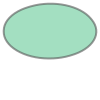

In [2]:
# define the place which we need to research
PLACE_OF_INTEREST = "Leeds City Centre, Leeds, United Kingdom"
# get the gdf by using osmnx.geocode_to_gdf() and set the distance of buffer at 1000 meters.
leeds_center = osmnx.geocode_to_gdf(PLACE_OF_INTEREST, buffer_dist=1000)

# From this take the polygon that defines Leeds's boundary
leeds_polygon = leeds_center['geometry'][0]
# we can see that the buffer is like an oval
leeds_polygon

In [3]:
# get the position of the Leeds City Centre which we choose to be the original area.
print("The coordinates of the area chosen is (Lat:{},Lon:{}).".format(leeds_center.lat.values,leeds_center.lon.values))

The coordinates of the area chosen is (Lat:[53.8091284],Lon:[-1.53023679]).


## 1.2 Data Processing

In [4]:
USE_COLS = ['Grid Ref: Easting', 'Grid Ref: Northing']
# choose the data in nearly five years.
year_list = ["2015","2016","2017","2018","2019"]
# creat a list to store the data
leeds = []
for i in range(len(year_list)):
    leeds_df = pd.read_csv("./" +'Leeds_RTC_'+ year_list[i] +'.csv',encoding='ISO-8859-1')
    leeds.append(leeds_df)
# drop the column named "Channel" and "Region"
# merge the five years data into one dataframe.
leeds_df = pd.concat([x for x in leeds],axis=0,ignore_index=True)
leeds_df = leeds_df.dropna(subset=USE_COLS)


In [ ]:
leeds_df.head(5)

## 1.3 Converting the Reference Coordinate System

In [6]:
#  In the data file, the coordinate format is ‘Grid Reference'. So we need to change it to the longitude and latitude coordinate system.
gdf = geopandas.GeoDataFrame(
    leeds_df, geometry=geopandas.points_from_xy(leeds_df["Grid Ref: Easting"], leeds_df["Grid Ref: Northing"],crs="EPSG:27700"))
gdf_new=gdf.to_crs(epsg=4326).drop(['Grid Ref: Northing','Grid Ref: Easting'],axis=1)


In [8]:
# get the accident points with their position.
accident_points = gdf_new.geometry
# Now, choosing the accident points which are inside the chosen area.
leeds_accident = gdf_new[accident_points.within(leeds_polygon)]
len(leeds_accident)
# we could find that there are 727 accidents in the chosen area, which is larger than 300.

727

Lowered zoom level to keep map size reasonable. (z = 14)


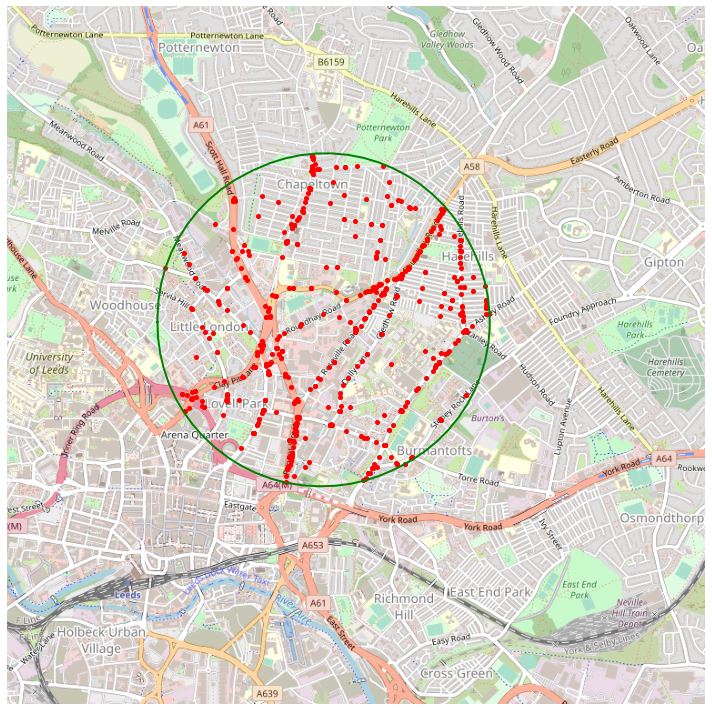

In [9]:
# in order to show the result of the accident points with the defined area, I draw them together.
tt = leeds_accident.geometry
box_stations = (tt.y.min(),tt.x.min(),
       tt.y.max(), tt.x.max())
map = smopy.Map(box_stations, z=1000) # z is the zoom level, here we set it as 10, you may want to try another value.
# map.show_ipython()
p1 = pd.Series(leeds_polygon.exterior.coords.xy[1].tolist())
p2 = pd.Series(leeds_polygon.exterior.coords.xy[0].tolist())
x1, y1 = map.to_pixels(tt.y, tt.x)
x2, y2 = map.to_pixels(p1,p2)
ax = map.show_mpl(figsize=(12, 10))
ax.plot(x1, y1, 'or', ms=4, mew=1) # 'or' means red dots/circles
ax.plot(x2, y2, color='green', linestyle='solid',linewidth=2, markersize=12)


## 1.4 The Research of The Characteristics of Road Network

In [10]:
# get the network of streets in Leeds city centre
leeds_graph = osmnx.graph_from_polygon(leeds_polygon,network_type = 'drive')

In [11]:
nx.check_planarity(leeds_graph)


(True, <networkx.algorithms.planarity.PlanarEmbedding at 0x1364fc5a130>)

In [12]:
# The function is cited by the codes from https://github.kcl.ac.uk/k2143309/7CUSMNDA/blob/master/notebooks/week_2b.ipynb 
def print_graph_statistics(graph):
    print("Number of nodes: {}\nNumber of edges: {}".format(
        graph.number_of_nodes(), graph.number_of_edges()
    ))
    
print_graph_statistics(leeds_graph)

Number of nodes: 714
Number of edges: 1657


In [13]:
leeds_area = osmnx.project_gdf(leeds_center).unary_union.area
osmnx.basic_stats(leeds_graph, area=leeds_area)
# the number of the junctions is 714
# the number of streets is 1657

{'n': 714,
 'm': 1657,
 'k_avg': 4.641456582633054,
 'edge_length_total': 109574.82299999992,
 'edge_length_avg': 66.12843874471932,
 'streets_per_node_avg': 2.696078431372549,
 'streets_per_node_counts': {0: 0, 1: 151, 2: 14, 3: 453, 4: 94, 5: 1, 6: 1},
 'streets_per_node_proportions': {0: 0.0,
  1: 0.211484593837535,
  2: 0.0196078431372549,
  3: 0.634453781512605,
  4: 0.13165266106442577,
  5: 0.0014005602240896359,
  6: 0.0014005602240896359},
 'intersection_count': 563,
 'street_length_total': 61626.72199999998,
 'street_segment_count': 929,
 'street_length_avg': 66.33662217438103,
 'circuity_avg': 1.0283500188893995,
 'self_loop_proportion': 0.0,
 'node_density_km': 213.2203272391748,
 'intersection_density_km': 168.12751293509163,
 'edge_density_km': 32722.100304250194,
 'street_density_km': 18403.459147783822}

In [14]:
# Some edges (roads in Leeds Center) are missing a geometry, so we will create one
# assuming that the road is a direct line from start point to end point.
# First, we need to get the locations of the points
x_values = nx.get_node_attributes(leeds_graph, 'x')
y_values = nx.get_node_attributes(leeds_graph, 'y')

# We will work with the edges and add the missing geometries (lines denoting the roads between points)
graph_with_geometries = list(leeds_graph.edges(data=True))

# Iterate through the edges and, where missing, add a geometry attribute with the line between start and end nodes
for e in graph_with_geometries:
    if not 'geometry' in e[2]:
        e[2]['geometry'] = LineString([
            Point(x_values[e[0]], y_values[e[0]]),
            Point(x_values[e[1]], y_values[e[1]])])

graph_with_geometries[0:4]

[(9823138,
  8674727247,
  {'osmid': 491178802,
   'oneway': True,
   'lanes': '2',
   'ref': 'A61',
   'name': 'Regent Street',
   'highway': 'trunk',
   'maxspeed': '30 mph',
   'length': 75.411,
   'geometry': <shapely.geometry.linestring.LineString at 0x1364fb53940>}),
 (9823138,
  52162260,
  {'osmid': 53014871,
   'oneway': True,
   'name': 'Byron Street',
   'highway': 'unclassified',
   'maxspeed': '20 mph',
   'length': 78.63,
   'geometry': <shapely.geometry.linestring.LineString at 0x1365048d580>}),
 (9823212,
  304904881,
  {'osmid': 23120678,
   'name': 'Skinner Lane',
   'highway': 'tertiary',
   'maxspeed': '30 mph',
   'oneway': False,
   'length': 11.47,
   'geometry': <shapely.geometry.linestring.LineString at 0x1364fb2d280>}),
 (9823212,
  395469503,
  {'osmid': 38422455,
   'oneway': True,
   'lanes': '2',
   'ref': 'A61',
   'name': 'Regent Street',
   'highway': 'trunk',
   'length': 67.194,
   'geometry': <shapely.geometry.linestring.LineString at 0x1364fb2d7f0>}

In [15]:
# 1657 streets
len(graph_with_geometries)

1657

# Task B: The Investigation of Road Network

In [16]:
# We will now drop the start and end nodes, as we will construct a new Spaghetti network based on the geometries of the roads
road_lines = [x[2] for x in graph_with_geometries]
# From this, we can construct a GeoDataFrame
roads_geodataframe = GeoDataFrame(pd.DataFrame(road_lines))
roads_geodataframe

,osmid,oneway,lanes,ref,name,highway,maxspeed,length,geometry,bridge,junction,access
0,491178802,True,2,A61,Regent Street,trunk,30 mph,75.411,"LINESTRING (-1.53312 53.80234, -1.53294 53.80301)",NaN,NaN,NaN
1,53014871,True,NaN,NaN,Byron Street,unclassified,20 mph,78.630,"LINESTRING (-1.53312 53.80234, -1.53321 53.802...",NaN,NaN,NaN
2,23120678,False,NaN,NaN,Skinner Lane,tertiary,30 mph,11.470,"LINESTRING (-1.53260 53.80366, -1.53276 53.80369)",NaN,NaN,NaN
3,38422455,True,2,A61,Regent Street,trunk,NaN,67.194,"LINESTRING (-1.53260 53.80366, -1.53276 53.80306)",NaN,NaN,NaN
4,"[169591262, 440408598, 169591263]",False,2,NaN,Skinner Lane,tertiary,30 mph,208.127,"LINESTRING (-1.53260 53.80366, -1.53252 53.803...",yes,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1652,82898611,False,NaN,NaN,Ashton View,residential,NaN,135.684,"LINESTRING (-1.51692 53.80960, -1.51485 53.80965)",NaN,NaN,NaN
1653,6009999,False,NaN,NaN,Bexley Terrace,residential,NaN,121.688,"LINESTRING (-1.51734 53.80928, -1.51912 53.80957)",NaN,NaN,NaN
1654,82898551,False,NaN,NaN,Ashton Place,residential,NaN,90.648,"LINESTRING (-1.51679 53.80909, -1.51661 53.809...",NaN,NaN,NaN
1655,6010000,False,NaN,NaN,Bexley Grove,residential,NaN,23.294,"LINESTRING (-1.51719 53.80897, -1.51754 53.80903)",NaN,NaN,NaN


In [17]:
# From the GeoDataFrame, we can construct a network in Spaghetti from which to do point analysis
leeds_points_graph = spaghetti.Network(in_data=roads_geodataframe)

## 2.1 Road Accident Distribution Visualization

<AxesSubplot:>

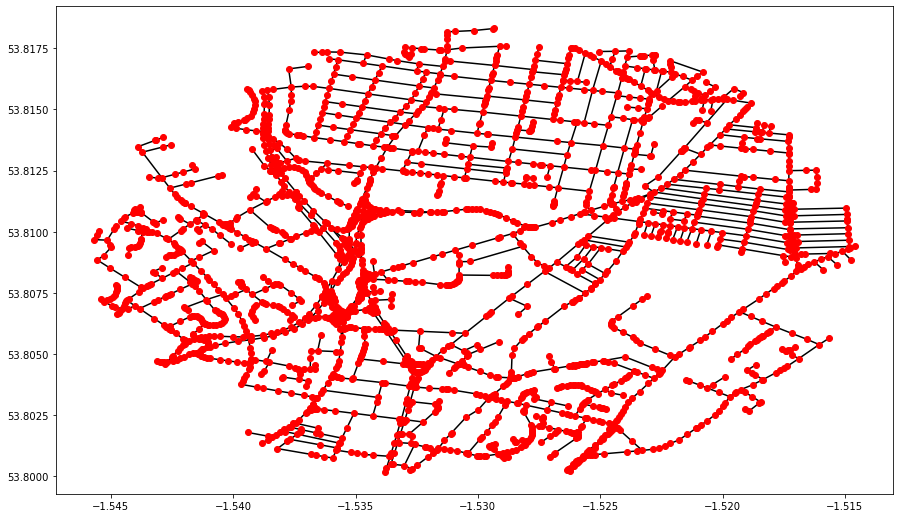

In [18]:
# Check what this new network looks like by getting DataFrames for the edges and plotting them
nodes_df, edges_df = spaghetti.element_as_gdf(
    leeds_points_graph, vertices=True, arcs=True)

base_network = edges_df.plot(color = "k", zorder=0, figsize=(15, 15))
nodes_df.plot(ax=base_network, color="r", zorder=2)


In [19]:
# We will now snap the leeds located accidents we extracted earlier, i.e. position them at the closest point on the closest road
leeds_points_graph.snapobservations(leeds_accident, 'accidents')

# We can see the difference between the original crime coordinates and their position when snapped to the road network
print("observation 1\ntrue coords:\t%s\nsnapped coords:\t%s" % (
    leeds_points_graph.pointpatterns["accidents"].points[0]["coordinates"],
    leeds_points_graph.pointpatterns["accidents"].snapped_coordinates[0]
))

observation 1
true coords:	(-1.5380278865147619, 53.8120329326295)
snapped coords:	(-1.538030088378504, 53.81203133539988)


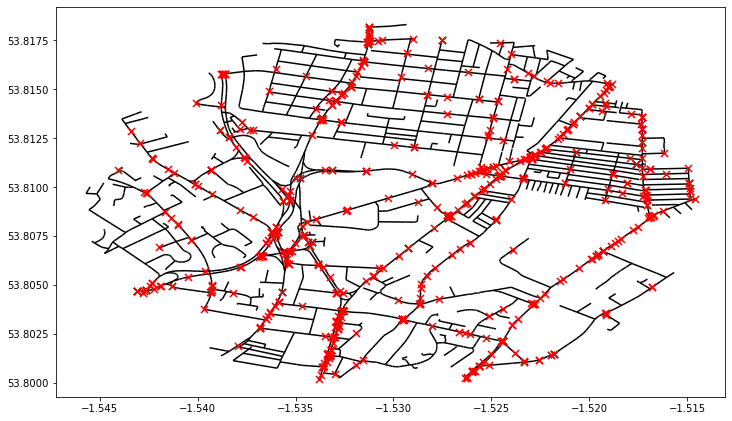

In [20]:
# Show the network
base_network = edges_df.plot(color="k", zorder=0, figsize =(12, 12))
# Get a GeoDataFrame of the snapped crime locations to plot on the network image
snapped_accidents=spaghetti.element_as_gdf(
    leeds_points_graph, pp_name='accidents', snapped=True)

# Plot these on the road network
snapped_accidents.plot(
    color="r", marker="x",
    markersize=50, zorder=1, ax=base_network)

plt.show()

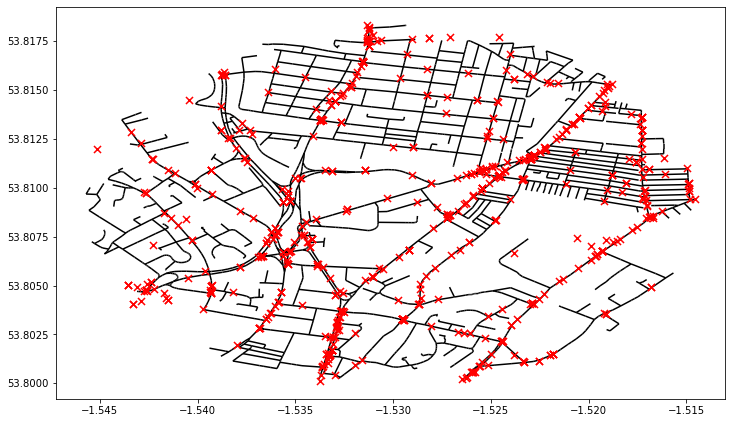

In [21]:
# Show the network
base_network = edges_df.plot(color="k", zorder=0, figsize =(12, 12))
# Get a GeoDataFrame of the non-snapped (real) crime locations to plot on the net
observed_accidents=spaghetti.element_as_gdf(
    leeds_points_graph, pp_name='accidents', snapped=False)

# Plot these on the road network
observed_accidents.plot(
    color="r", marker="x",
    markersize=50, zorder=1, ax=base_network)

plt.savefig('accidents-observations')

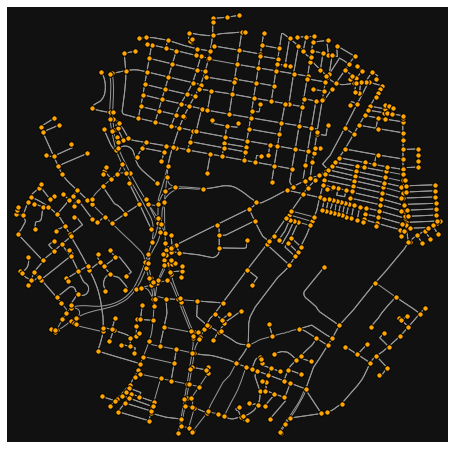

In [22]:
fig = osmnx.plot_graph(leeds_graph, node_color='orange', node_size=30,
node_zorder=2, node_edgecolor='k')


## 2.2 Accident Correlation Study

In [23]:
kres = leeds_points_graph.GlobalAutoK(
    leeds_points_graph.pointpatterns["accidents"],
    nsteps=100, permutations=100
)

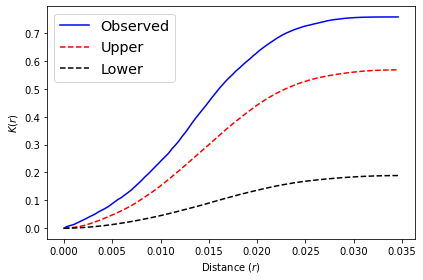

In [24]:
fig, ax = plt.subplots()

ax.plot(kres.xaxis, kres.observed, "b-", label="Observed")
ax.plot(kres.xaxis, kres.upperenvelope, "r--", label="Upper")
ax.plot(kres.xaxis, kres.lowerenvelope, "k--", label="Lower")

ax.legend(loc="best", fontsize="x-large")
ax.set_xlabel("Distance $(r)$")
ax.set_ylabel("$K(r)$")

fig.tight_layout()

In [25]:
# Get snapped point pattern 
pointpat = leeds_points_graph.pointpatterns['accidents']
# Get count of points per network edge: a dictionary from each edge to the crime count on that edge
counts = leeds_points_graph.count_per_link(pointpat.obs_to_arc, graph=False)

In [26]:
pp_name='accidents'
# leeds_points_graph
moran_ntwwn, yaxis_ntwwn = leeds_points_graph.Moran(pp_name,graph=True)
moran_ntwwn.I

0.1762283365240688

In [27]:
moran_ntwwn, yaxis_ntwwn = leeds_points_graph.Moran(pp_name)
moran_ntwwn.I

0.14739982039169233

(<Figure size 864x432 with 2 Axes>,
 array([<AxesSubplot:title={'center':'Reference Distribution'}, xlabel='Moran I: 0.15', ylabel='Density'>,
        <AxesSubplot:title={'center':'Moran Scatterplot (0.15)'}, xlabel='Attribute', ylabel='Spatial Lag'>],
       dtype=object))

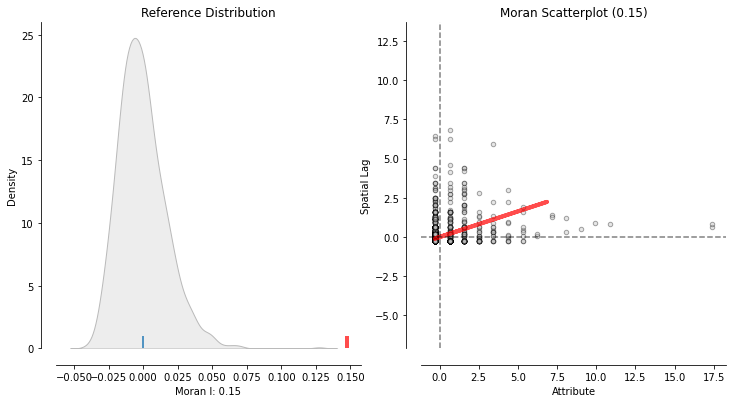

In [28]:
from splot.esda import moran_scatterplot, lisa_cluster, plot_moran
figsize = (12,6)
fitline_kwds = {"color":"r", "lw": 4, "alpha":.7}
scatter_kwds = {"s":20, "edgecolors":"k", "alpha":.35}
pltkwds = {"fitline_kwds": fitline_kwds, "scatter_kwds": scatter_kwds}
plot_moran(moran_ntwwn, zstandard=True, figsize=figsize, **pltkwds)
# almost all the points are gathering in the High-high quadrant.That is, the closer the street is, the easier it is for accidents to gather.

In [29]:
# Get the weights matrix for edges in the graph (just the adjacency matrix with 1 where edges connect at a node, 0 otherwise)
weights = leeds_points_graph.w_network

In [30]:
# Get the edges included in the weights matrix: an enumerator for a list of edges
edges = weights.neighbors.keys()
# Construct an array of the counts values per edge in the same order as
# the weights matrix, with 0.0 where no counts recorded
values = [counts[edge] if edge in counts.keys () else 0. \
    for index, edge in enumerate(edges)]

In [31]:
moran = esda.moran.Moran(values, weights)
moran.I
# 0.147>0

0.14739982039169233

In [32]:
moran.p_sim
# This means the car accidents are autocorrelated.

0.001

In [33]:
moran.EI
moran.EI_sim

print(moran.EI)

-0.0004068348250610252


In [34]:
moran.EI_sim

-0.0006516731787700627

In [35]:
moran.z_norm


8.170694257529647

In [36]:
moran.z_sim

8.469924424444127

In [37]:
# import matplotlib_scalebar
# from matplotlib_scalebar.scalebar import ScaleBar
# _, arc_df = spaghetti.element_as_gdf(leeds_points_graph, vertices=True, arcs=True)
# moran_loc_ntwwn = esda.moran.Moran_Local(yaxis_ntwwn, leeds_points_graph.w_network)
# pp_df = spaghetti.element_as_gdf(leeds_points_graph, pp_name=pp_name)
# p = 0.05
# lisa_args = moran_loc_ntwwn, arc_df
# f, ax = lisa_cluster(*lisa_args, **lisa_kwds)
# pp_df.plot(ax=ax, zorder=1, alpha=.25, color="g", markersize=30)
# plt.suptitle(suptitle, fontsize=20, x=.51, y=.93)
# plt.title(subtitle % pp_df.shape[0], fontsize=15)
# ax.add_artist(matplotlib_scalebar.scalebar.ScaleBar(1, **sbkw));

## 2.3 The Fraction Length of Accidents Locations 

In [38]:
snapped_accidents

,id,geometry,comp_label
0,0,POINT (-1.53803 53.81203),0
1,1,POINT (-1.51966 53.80649),0
2,2,POINT (-1.52330 53.80108),0
3,3,POINT (-1.52330 53.80108),0
4,4,POINT (-1.51967 53.80648),0
...,...,...,...
722,722,POINT (-1.53601 53.80757),0
723,723,POINT (-1.53570 53.80990),0
724,724,POINT (-1.52220 53.81199),0
725,725,POINT (-1.52220 53.81199),0


In [39]:
roads_geodataframe.geometry

0       LINESTRING (-1.53312 53.80234, -1.53294 53.80301)
1       LINESTRING (-1.53312 53.80234, -1.53321 53.802...
2       LINESTRING (-1.53260 53.80366, -1.53276 53.80369)
3       LINESTRING (-1.53260 53.80366, -1.53276 53.80306)
4       LINESTRING (-1.53260 53.80366, -1.53252 53.803...
                              ...                        
1652    LINESTRING (-1.51692 53.80960, -1.51485 53.80965)
1653    LINESTRING (-1.51734 53.80928, -1.51912 53.80957)
1654    LINESTRING (-1.51679 53.80909, -1.51661 53.809...
1655    LINESTRING (-1.51719 53.80897, -1.51754 53.80903)
1656    LINESTRING (-1.54178 53.80814, -1.54170 53.808...
Name: geometry, Length: 1657, dtype: geometry

In [40]:

X = snapped_accidents.geometry.x
Y = snapped_accidents.geometry.y
# get which street is the closest to each accident point.
Dist_PtoS = osmnx.distance.nearest_edges(leeds_graph, X, Y, interpolate=None, return_dist=False)


The closest distance to the street is 0

In [41]:
Dist_PtoS

[(49536058, 49536064, 0),
 (249319325, 31938496, 0),
 (249614209, 249614210, 0),
 (249614209, 249614210, 0),
 (249319325, 31938496, 0),
 (964816532, 249813617, 0),
 (52162219, 52162211, 0),
 (8978484482, 964814245, 0),
 (9823212, 1790247699, 0),
 (9270563905, 249619867, 0),
 (982573860, 982573835, 0),
 (146657080, 84445320, 0),
 (146657080, 84445320, 0),
 (84445302, 84445309, 0),
 (8674727247, 304904881, 0),
 (249621263, 2164672131, 0),
 (49555947, 49572604, 0),
 (146657050, 3071000863, 0),
 (146657050, 3071000863, 0),
 (245495726, 964816079, 0),
 (52690659, 52690656, 0),
 (249810450, 249810452, 0),
 (10456833, 964816317, 0),
 (10456833, 964816317, 0),
 (52162276, 395469494, 0),
 (52690792, 982576511, 0),
 (245494220, 245494221, 0),
 (245494220, 245494221, 0),
 (2370866783, 8978484491, 0),
 (395486413, 249614209, 0),
 (395486413, 249614209, 0),
 (52690786, 245494258, 0),
 (245494258, 52690606, 0),
 (10456853, 964816070, 0),
 (10456888, 10456870, 0),
 (10456870, 10456833, 0),
 (30591943

In [42]:
len(Dist_PtoS)

727

In [43]:
Dist_PtoS[0][0]

49536058

In [44]:
leeds_graph.nodes()[8674727247]['x']

-1.5329448

In [45]:
dist = []
fraction = []
for i in range(len(Dist_PtoS)):
    node_start = Dist_PtoS[i][0]
    node_end = Dist_PtoS[i][1]
    # p1 is the accident point
    p1 = (Y[i],X[i])
    # p2 are the start and the end of the street where p1 was happened .
    p2_start = (leeds_graph.nodes()[node_start]['y'],leeds_graph.nodes()[node_start]['x'])
    p2_end = (leeds_graph.nodes()[node_end]['y'],leeds_graph.nodes()[node_end]['x'])
    street_length = haversine(p2_end,p2_start,unit='km')
    dist_start = haversine(p1,p2_start,unit='km')
    dist_end = haversine(p1,p2_end,unit='km')
    if dist_start>=dist_end:
        dist.append(dist_end)
        frac = dist_end/street_length
        fraction.append(frac)
    else:
        dist.append(dist_start)
        frac = dist_start/street_length
        fraction.append(frac)


In [46]:
ave_dist = sum(dist)/len(dist)
ave_fraction = sum(fraction)/len(fraction)
road_fraction = round(ave_fraction*100, 2)
print('The average distance between accident point to the intersection is {} km.'.format(ave_dist)) #km
print('The average fraction of the nearest intersection to accident point is {}%.'.format(road_fraction))# Proportion

The average distance between accident point to the intersection is 0.01594097856874634 km.
The average fraction of the nearest intersection to accident point is 17.79%.
